In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os

import scipy
import networkx as nx

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from numpy import linalg as LA

In [2]:
seed = 42
no_users = 10

In [3]:
from sklearn.datasets import make_regression

n_samples, n_features = 1000, 10
rng = np.random.RandomState(seed)
X, y, d_opt = make_regression(n_samples, n_features, coef=True, random_state=rng)

In [4]:
y = y.reshape(-1,1)
d_opt = d_opt.reshape(-1,1)

In [5]:
def random_split(X, y, n, seed):
    """Equally split data between n agents"""
    rng = np.random.default_rng(seed)
    perm = rng.permutation(y.size)
    X_split = np.array_split(X[perm], n)  #np.stack to keep as a np array
    y_split = np.array_split(y[perm], n)
    return X_split, y_split

In [6]:
def loss(w, A, b):
    z = b - np.dot(A, w)
    loss = 1/2*(np.linalg.norm(z)**2)
    return loss

In [7]:
def degrees(A):
    """Return the degrees of each node of a graph from its adjacency matrix"""
    return np.sum(A, axis=0).reshape(A.shape[0], 1)

In [8]:
def generate_graph(n, seed):
    """Generate a random connected graph"""
    while True:
        g = nx.generators.random_graphs.binomial_graph(n, 0.4, seed = seed) 
        # g = nx.random_geometric_graph(n, 0.4, seed = seed)
        #g = nx.grid_2d_graph(int(n/2), int(n/5))
        if nx.algorithms.components.is_connected(g):
            return g

In [9]:
def neighbors(A, i):
    """Return the indices of node i's neighbors from adjacency matrix"""
    return np.argwhere(A[i, :] == 1)[:, 1]

In [10]:
G = generate_graph(no_users, seed)
adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(G)
print(G.number_of_edges())
print(G.number_of_nodes())
#

20
10


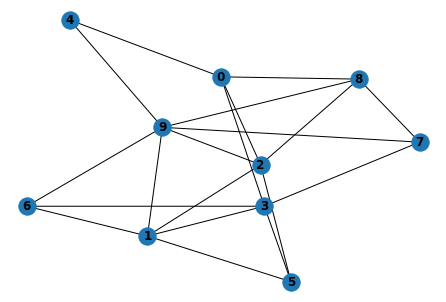

In [11]:
nx.draw(G, with_labels=True, font_weight='bold')

In [12]:
num_feature = X.shape[1]
In = nx.incidence_matrix(G,oriented=True).toarray()

In [13]:
new_incidence_matrix = np.kron(In,np.eye(num_feature))

In [14]:
new_incidence_matrix.shape

(100, 200)

In [15]:
# Optimal objective function, i.e., f(x*)
obj0 = loss(d_opt, X, y)

In [16]:
X.shape

(1000, 10)

In [17]:
y.shape

(1000, 1)

In [18]:
gg=np.matmul(np.matmul(X.T,X),d_opt)-np.matmul(X.T,y)

In [19]:
gg.shape

(10, 1)

In [20]:
gg

array([[-7.27595761e-12],
       [-1.45519152e-11],
       [ 3.63797881e-12],
       [-1.81898940e-12],
       [ 6.82121026e-13],
       [-7.27595761e-12],
       [ 7.27595761e-12],
       [ 0.00000000e+00],
       [ 3.63797881e-12],
       [-1.45519152e-11]])

In [21]:
obj0

1.5715144611940658e-25

In [22]:
X, y = random_split(X, y, no_users, seed)

theta = [np.zeros([num_feature,1]) for _ in range(no_users)] # initial model

d = [np.zeros([num_feature,1]) for _ in range(no_users)] # direction

lamd = np.zeros([num_feature*G.number_of_edges(),1])  # dual variables

In [23]:
n_iters = 1
losses_dnl = []
re_dcg = np.zeros(shape=[n_iters])
d0 = np.zeros([num_feature,1])

for k in range(n_iters):
    print(k)
    
    for i in range(no_users):
        II=new_incidence_matrix[i*num_feature:(i+1)*num_feature,:] #-->Ai.T
        Hess = np.matmul(X[i].T, X[i])
        grad = np.matmul(X[i].T, y[i])
        d[i] = np.matmul(np.linalg.inv(Hess), grad + np.matmul(II,lamd)) #
            
    # Dual Variable Update
    Si_sum = np.zeros([num_feature*G.number_of_edges(),num_feature*G.number_of_edges()])
    zi_sum = np.zeros([num_feature*G.number_of_edges(),1])
    for i in range(no_users):
        II=new_incidence_matrix[i*num_feature:(i+1)*num_feature,:]
        Hess = np.matmul(X[i].T, X[i])
        grad = np.matmul(X[i].T, y[i])
        Hinv = np.linalg.inv(Hess)
        Si_sum = Si_sum + np.matmul(np.matmul(II.T,Hinv),II)
        zi_sum = zi_sum + np.matmul(np.matmul(II.T,Hinv),grad)
    
    lamd = -np.matmul(np.linalg.inv(Si_sum),zi_sum) 
      
    d_avg = 1/no_users*sum(d)   
    #loss_dnl = 1/no_users*sum([loss(d_avg, X[i], y[i]) for i in range(no_users)])
    re_dcg[k] = np.linalg.norm(d_avg-d_opt)/np.linalg.norm(d0-d_opt)

0


In [25]:
re_dcg

array([1.78226176e-16])